# Project: Finding Lane Lines on the Road

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, y_start, color=[255, 0, 0], thickness=2):
    """
    `img` is to be drawn by this function
    `lines` are Hough lines
    `y_start' specifies how far down the road should the averaged line be drawn
    `color` of the lines
    `thickness` of the lines
    
    Hough lines are split into left lanes and right lanes by their x positions.
    The x and y positions for each lane are fitted with a linear line (least squares)
    then drawn onto the `img`
        
    """
    # ------------------------------------------------------------------------------
    # Split the lines into left and right lanes based on their x position
    x_RightLane = []
    y_RightLane = []
    x_LeftLane = []
    y_LeftLane = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x1 >img.shape[1]*0.5 and x2 > img.shape[1]*0.5):
                x_RightLane.append(x1)
                x_RightLane.append(x2)
                y_RightLane.append(y1)
                y_RightLane.append(y2)
            elif (x1 < img.shape[1]*0.5 and x2 < img.shape[1]*0.5):
                x_LeftLane.append(x1)
                x_LeftLane.append(x2)
                y_LeftLane.append(y1)
                y_LeftLane.append(y2)
    
    # ------------------------------------------------------------------------------
    # Polynomial fit of first order (linear fit using least squares)
    p_RightLane = np.polyfit(x_RightLane, y_RightLane, 1)
    p_LeftLane = np.polyfit(x_LeftLane, y_LeftLane, 1)

    # ------------------------------------------------------------------------------
    # Left lane
    x1 = int((img.shape[0] - p_LeftLane[1])/p_LeftLane[0])
    y1 = img.shape[0]
    x2 = int((y_start - p_LeftLane[1])/p_LeftLane[0])
    y2 = int(y_start)

    cv2.line(img, (x1, y1), (x2, y2), [255, 0, 0], 10)

    # ------------------------------------------------------------------------------
    # Right lane
    x1 = int((y_start - p_RightLane[1])/p_RightLane[0])
    y1 = int(y_start)
    x2 = int((img.shape[0] - p_RightLane[1])/p_RightLane[0])
    y2 = img.shape[0]

    cv2.line(img, (x1, y1), (x2, y2), [255, 0, 0], 10)
    
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, y_start):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, y_start)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [3]:
def process_image(image):    
    # Note: always make a copy rather than simply using "="
    color_select = np.copy(image)

    # ------------------------------------------------------------------------------
    # Define our color selection criteria
    # ------------------------------------------------------------------------------
    # these thresholds would be better if they adjust with brightness of the image
    red_threshold = 220
    green_threshold = 220
    blue_threshold = 5 # color blue are excluded if above this threshold

    # Note that the threshold are designed so only white and yellow colors are left
    thresholds = (image[:,:,0] < red_threshold) \
                & (image[:,:,1] < green_threshold) \
                & (image[:,:,2] > blue_threshold)
            
    color_select[thresholds] = [0,0,0]

    # ------------------------------------------------------------------------------
    # Apply guassian blur and Canny transform
    # ------------------------------------------------------------------------------
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(grayscale(color_select), kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 100
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # ------------------------------------------------------------------------------
    # Define region of interest
    # ------------------------------------------------------------------------------
    # these numbers are found with trial and error and are relative to the number of pixels
    # will need to be scaled if the camera is positioned differently, i.e. on the dashboard
    
    # this parameter defines how far down the road to "look"
    # not a very good way to define this and would not work if for example the car is about
    # to travel downhill
    # The road are approximately the same color and the borderline is approximately horizontal
    # perhaps we can use them to define this parameter
    y_initial = image.shape[0] * 0.6

    vertices = np.array([[(image.shape[1]*0.05,image.shape[0]), \
                          (image.shape[1]*0.45, y_initial), \
                          (image.shape[1]*0.55, y_initial), \
                          (image.shape[1]*0.95,image.shape[0])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    
    # ------------------------------------------------------------------------------
    # Hough transform
    # ------------------------------------------------------------------------------
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    # distance resolution in pixels of the Hough grid
    rho = 1 
    # angular resolution in radians of the Hough grid
    theta = np.pi/180 
    # minimum number of votes (intersections in Hough grid cell)
    threshold = 5
    # minimum number of pixels making up a line
    min_line_length = 5
    # maximum gap in pixels between connectable line segments
    max_line_gap = 20

    lines_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, y_initial)

    # ------------------------------------------------------------------------------
    # Draw lines on original image
    # ------------------------------------------------------------------------------
    weightedLines = weighted_img(lines_edges, image)
    
    return weightedLines

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

### Obtain a List of Unmodified Images
Already processed images are excluded from the list

In [4]:
import os
imageFileNames = os.listdir("test_images/")

originalImageFileNames = [];

for imageFileName in imageFileNames:
    if 'Processed_' not in imageFileName:
        originalImageFileNames.append(imageFileName)

print(originalImageFileNames)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


### Process Original Images and Save
Processed images are saved under the same folder with `'Processed_'` inserted before the original file name

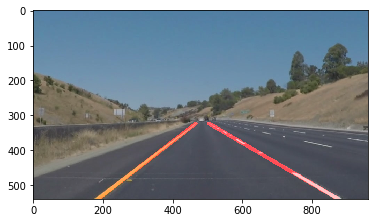

In [5]:
for originalImageFileName in originalImageFileNames:
    image = mpimg.imread('test_images/'+ originalImageFileName)
    
    processedImage = process_image(image)
    
    plt.imshow(processedImage)
    
    mpimg.imsave('test_images/' + 'Processed_' + originalImageFileName, processedImage)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 27.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 8.41 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:24<00:00, 27.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 24.9 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:17<00:00, 14.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 18.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))